# Product 'Hint' - Empirical Guidelines for Effective Social Product Launching

## Research Goal

The main goal of this research is to understand what factors drive to successful app 
launching on Product Hunt (PH), where *success* is defined as whether a product is 
featured among the daily popular on the PH homepage. Popular app are upvoted by 
community members.

Products are discovered by a 'hunter' on PH, a community members who scavages the Internet
seeking new applications. Sometimes the hunter is also one of the app 'makers' who want
to launch and advertise a new product -- as being featured among the PH's daily popular
represent a considerable boost in visibility. 

PH has compiled a set of publicly available [guidelines](?) for successful launches, yet we do 
not know whether these rules are implemented by community members and, in case, if they work.
In our previous work on Stack Overflow (SO), we empirically verified that some of the 
recommended guidelines provided by SO do not actually work and, when they do, they are 
seldom [F. Calefato et al. “How to Ask for Technical Help?
 Evidence-based Guidelines for Writing Questions on Stack Overflow.” IST 2018, 94:186-207, 
 DOI: 10.1016/j.infsof.2017.10.009](https://arxiv.org/ftp/arxiv/papers/1710/1710.04692.pdf).

## Research Question

The broad research question that this experiment investigates is the following:
***What factors are predictive of the number of upvotes on PH?***


## Model development

### Dependent variable

*Score*: a positive integer, the number of upvotes received by community members who appreciate
the application.

Because the score is left-censored (bounded by zero) counter, the most suitable approach 
appears to build a count data model, as these models have a dependent variable that is 
counts (i.e., 0, 1, 2, 3, and so on).


### Predictive factors (independent vars)

Regarding the factors, we are considering
* *Reputation*, of both the hunter and the maker, if different
* *Time*, when the product is hunted/launched (posted, from now on); as the homepage is 
refreshed at 12:01am PST on a 24h-cycle, the recommended best practice is to post at 
9:00 am PST so that there is enough time in the day for people to discover and discuss
an application. Also, weekends tend to be slower, so recommended days are Mondays and 
Tuesdays. 
* *Presentation quality*, which is achieved in different ways such as using a short, catchy 
tagline, using animated GIFs, YouTube videos, and emoji. Also the length of textual description 
may have an effect, as guidelines recommend to be specific. 
* *Sentiment (or affect)*, as in the positive, negative, neutral orientation conveyed by the textual
description of the tool, which may or may not affect the number of upvotes received (i.e., score).
* *Nurturing*, or whether the maker engages in the discussion with the other members who 
leave comments and reviews. A participating and communicative maker may foster a more favorable 
judgment for the tool and, hence, attract more upvotes.

These points should be rewritten in form of testable hypotheses, one or more per factor.

## Analysis workflow
 
### 1. Feature extraction & cleaning


In [6]:
from analysis.features import extraction

extraction.main()


[2019-06-27 14:50:23,434 - ph_feature_extraction - WARNING]: Time-based features extraction unimplemented
[2019-06-27 14:50:23,434 - ph_feature_extraction - WARNING]: Time-based features extraction unimplemented
[2019-06-27 14:50:23,434 - ph_feature_extraction - WARNING]: Time-based features extraction unimplemented
[2019-06-27 14:50:23,434 - ph_feature_extraction - WARNING]: Time-based features extraction unimplemented
[2019-06-27 14:50:23,460 - ph_feature_extraction - WARNING]: Linguistic features extraction unimplemented
[2019-06-27 14:50:23,460 - ph_feature_extraction - WARNING]: Linguistic features extraction unimplemented
[2019-06-27 14:50:23,460 - ph_feature_extraction - WARNING]: Linguistic features extraction unimplemented
[2019-06-27 14:50:23,460 - ph_feature_extraction - WARNING]: Linguistic features extraction unimplemented
[2019-06-27 14:50:23,552 - ph_feature_extraction - WARNING]: Affect-based features extraction unimplemented
[2019-06-27 14:50:23,552 - ph_feature_extrac

### 2. Model building

#### Correlation analysis


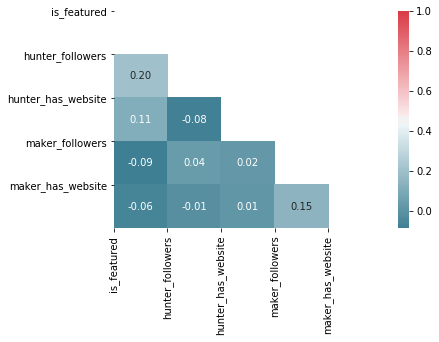

In [1]:
from matplotlib import pyplot
import seaborn
import pandas
import numpy
%matplotlib inline

df = pandas.read_csv('features.csv',
                     sep=';',
                     header=0,
                     index_col=0,
                     encoding='utf-8')

corr = df[['is_featured', 'hunter_followers', 'hunter_has_website', 'maker_followers', 'maker_has_website']].corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)
# Drop self-correlations
dropSelf = numpy.zeros_like(corr)
dropSelf[numpy.triu_indices_from(dropSelf)] = True
# Generate Color Map
colormap = seaborn.diverging_palette(220, 10, as_cmap=True)
# Generate Heat Map, allow annotations and place floats in map
seaborn.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)
# Apply ticks
pyplot.xticks(range(len(corr.columns)), corr.columns);
pyplot.yticks(range(len(corr.columns)), corr.columns)
pyplot.show()


#### Logistic Regression model

We test whether the likelihood of a post to be featured on PH homepage is associated
with the reputation of its hunter and maker -- where having a Twitter account, a webiste, and the number of Twitter 
followers are used as proxy for each. Specifically:

```
is_featured ~ hunter_followers + hunter_has_website 
              + maker_followers + maker_has_website
```


In [1]:
import pandas
import numpy
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
import seaborn

y = df.is_featured
cols = ['hunter_followers', 'hunter_has_website', 'maker_followers', 'maker_has_website']
X = df[cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)


NameError: name 'df' is not defined

#### Model performance: confusion matrix


In [ ]:
y_pred=logreg.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print("Accuracy: ", round(metrics.accuracy_score(y_test, y_pred),3))
print("Precision: ", round(metrics.precision_score(y_test, y_pred), 3))
print("Recall: ", round(metrics.recall_score(y_test, y_pred), 3))

class_names=['not featured', 'featured'] # name  of classes
fig, ax = pyplot.subplots()
tick_marks = numpy.arange(len(class_names))
pyplot.xticks(tick_marks, class_names)
pyplot.yticks(tick_marks, class_names)
seaborn.heatmap(pandas.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
pyplot.tight_layout()
pyplot.title('Confusion matrix', y=1.1)
pyplot.ylabel('Actual')
pyplot.xlabel('Predicted')
pyplot.show()


#### Model performance: ROC 


In [ ]:
y_pred_proba = logreg.predict_proba(X_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
pyplot.subplots()
pyplot.plot(fpr, tpr, label="auc=" + str(round(auc, 3)))
pyplot.legend(loc=4)
pyplot.title('ROC')
pyplot.show()